In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
from IPython.core.display import HTML
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, chi2_contingency, mannwhitneyu, wilcoxon
from statsmodels.stats.proportion import proportions_ztest
import warnings
warnings.filterwarnings('ignore')

In [2]:
with open("CSS_adage", "r") as f:
    css_style = f.read()

display(HTML(f'<style>{css_style}</style>'))

<h1>Background</h1>

<div class = 'all'>
    <p>The data used in this project is from the <span class = 'small-caps'><b>A</b>ssessment of <b>D</b>irect oral <b>A</b>nticoagulants in <b>GE</b>riatrics </span> (<span class = 'small-caps'>Adage</span>) study. It is a European prospective, multicenter, non-interventional phase IV academic clinical trial 
    </p>
    <br>
    <b>Objectives of the <span class = 'small-caps'>Adage</span> study:</b>
        <ul>
            <li>The main objective of this study was to assess the <b>inter-individual variability of response</b> of rivaroxaban, apixaban and dabigatran in patients over <b>80 years old</b> with atrial fibrillation (AF).</li>
            <li>The secondary objective was to collect haemorrhagic and thrombotic events and deaths at six months follow-up.</li>
        </ul> 
    <br><b>Rationale of the <span class = 'small-caps'>Adage</span> study</b>
    <p>Patients over the age of 80 constitute a particularly fragile population. With a prevalence of atrial fibrillation exceeding 10%, octogenarians are increasingly benefiting from direct oral anticoagulants (DOACs). While these drugs have been extensively studied in healthy volunteers, patients included in clinical trials and those in registries [1]-[12], there is little specific data published on patients aged 80 and over with atrial fibrillation.</p>
    <p>
For further information about <span style = 'font-variant : small-caps'>Adage</span> please refer to <a href = 'https://pubmed.ncbi.nlm.nih.gov/36395818/'>this article</a> published in <i>Thrombosis and Haemostasis</i> in April 2023.
    </p></div>
<br><div class = 'obj'>
    <p><b>Objectives of this project</b></p>   
    <ul>
        <li> To provide a comprehensive overview of the characteristics of elderly patients with atrial fibrillation in the <span class = 'small-caps'>Adage</span> clinical trial, including demographic, clinical, laboratory, and medication data.</li>
        <li>To identify potential gender differences in the characteristics of elderly patients with atrial fibrillation, and explore potential reasons for any observed differences.</li>
        <li>To highlight trends in medication prescriptions among elderly patients with atrial fibrillation and multiple comorbidities in the <span style = 'font-variant : small-caps'>Adage</span> trial.</li>
        <li>To explore the potential impact of genetic factors on the characteristics of elderly patients with atrial fibrillation in the <span style = 'font-variant : small-caps'>Adage</span> trial.</li>
        <li>To demonstrate proficiency in data visualisation using Python and associated libraries, including Pandas, Matplotlib, and Seaborn.</li>
    </ul>
    <p>And overall, to provide a valuable resource for future researchers interested in understanding the characteristics of elderly patients with atrial fibrillation.</p>
</div>

<br><div class = 'all'>
   <p><i>Please note that the results presented here may differ slightly from what has been published in scientific papers or presented at conferences. The data presented here concerns the entire cohort of patients included in the study at the termination date, while published data may concern subgroups of patients.</i></p>

</div>

<h1>Abbreviations</h1> 

<ul>
    <li>ACEI: Angiotensin-converting-enzyme inhibitors</li>
    <li><span class = 'small-caps'>Adage</span>: Assessment of Direct oral Anticogulants in GEriatrics</li>
    <li>AF: Atrial Fibrillation</li>
    <li>ARBs: Angiotensine receptors blockers</li>
    <li>BMI: Body-mass index</li>
    <li>CRP: C-reactive protein</li>
    <li>DOAC: Direct Oral Anticoagulant</li>
    <li>GFR: Glomerular filtration rate</li>
    <li>NSAID: Non-steroidal anti-inflammatory drug</li>
    <li>SNRA: Serotonin–norepinephrine releasing agent</li>
    <li>SSRI: Selective serotonin reuptake inhibitors</li>
</ul>

<h1>Preliminary work</h1>
<h2>Preprocessing</h2>

In [3]:
patients_raw = pd.read_csv('bdd_adage_viz_patients.csv', sep = ';')

#Importing a list of columns to be deleted and a dict storing informations on columns renaming.

from adage_viz_dicts import col_rename_patients, col_to_delete_patients
patients = patients_raw.drop(col_to_delete_patients, axis = 1)
patients.rename(col_rename_patients, axis = 1, inplace = True)

#Creating new features from existing columns and changing inclusion date into a date object
patients['encoded_abcb1_21'] = patients['abcb1_21'].apply(lambda x: 0 if x == 'GG' else(1 if x == 'GA' or x == 'GT' else (2 if x == 'AA' or x == 'AT' or x == 'TT' else x))).astype('Int64')
patients['encoded_abcb1_26'] = patients['abcb1_26'].apply(lambda x: 0 if x == 'CC' else(1 if x == 'CT' else (2 if x == 'TT' else x))).astype('Int64')
patients['encoded_abcb1_12'] = patients['abcb1_12'].apply(lambda x: 0 if x == 'CC' else(1 if x == 'CT' else (2 if x == 'TT' else x))).astype('Int64')
patients['encoded_cyp_2j2'] = patients['cyp_2j2'].apply(lambda x: 0 if x == 'GG' else(1 if x == 'GT' else (2 if x == 'TT' else x))).astype('Int64')
patients['encoded_cyp_3a5'] = patients['cyp_3a5'].apply(lambda x: 0 if x == 'AA' else(1 if x == 'GA' else (2 if x == 'GG' else x))).astype('Int64')
patients['incl_date'] = pd.to_datetime(patients.incl_date)
patients['kidneyf_class'] = patients.clcr_cockcroft.apply(lambda x: 'normal' if x >= 90 else('mildly decreased' if x >= 60 else('moderately decreased' if x >= 30 else ('severely decreased' if x >=0 else(None)))))

#Reencoding binary features as int

to_int = [
    'heartf', 'liverf', 'alcohol', 'coronary', 'stroke', 'cancer', 'haemopathy', 'dementia', 'cirsg_tot', 'cirsg_comp',
    'high_bp', 'diabetes', 'dyslipidaemia', 'smoke', 'obesity', 'chadsvasc_score', 'hasbled_score',
    'hemorrhages_score', 'nb_medications', 'amiodarone', 'verapamil', 'quinidine', 'clarithromycin', 'aspirin',
    'clopidogrel', 'other_antiplt', 'nsaid', 'bblocker', 'acei', 'arbs', 'statin', 'completed_f6m', 'f6m_hospit',
    'f6m_transfusion', 'f6m_bleed', 'f6m_te', 'f6m_death', 'f6m_still_doac', 'completed_f12m', 'f12m_hospit',
    'f12m_transfusion', 'f12m_bleed', 'f12m_te', 'f12m_death', 'f12m_still_doac', 'is_crp_above_5', 
    'kidneyf_50', 'pgp_substrate_nb', 'pgp_inhib_nb', 'pgp_all_nb', 'pgp_1_all', 'pgp_1_substrate', 'pgp_1_inhib',
    'cyp_substrate_nb', 'cyp_inhib_nb', 'cyp_induct_nb', 'cyp_all_nb', 'cyp_1_all', 'cyp_1_substrate', 'cyp_1_inhib',
    'ssri', 'snra', 'ssri_snra', 'anticoagulant', 'amlodipine', 'alprazolam', 'atorvastatin', 'bisoprolol',
    'citalopram', 'diazepam', 'diltiazem', 'digoxin', 'irbesartan', 'lansoprazole', 'losartan', 'mirtazapine',
    'oxycodone', 'tamsulosin', 'simvastatin', 'hypnotic', 'cancer_haemopathy', 'plt_norm', 'hyperleuco', 'azole',
    'antiarr', 'any_anti_plt', 'f6m_lost', 'f12m_lost', 'f6_12m_bleed', 'f6_12m_te', 'f6_12m_major_bleed',
    'f6m_major_bleed', 'f12m_major_bleed', 'performed_any_tga', 'performed_fibrinography', 'performed_td',
    'performed_ds', 'performed_ts', 'performed_tm', 'non_valid_regimen', 'lower_regimen', 'higher_regimen'
]


for feature in to_int:
    patients[feature] = patients[feature].astype('Int64')

#Decoding categorical features and type change    

patients['fa_type'] = patients['fa_type'].apply(lambda x: 'paroxysmal' if x == 1.0 else('persistent' if x == 2.0 else('permanent' if x == 3.0 else(x)))).astype('category')

category_kidneyf = pd.CategoricalDtype(categories=['normal','mildly decreased','moderately decreased','severely decreased'], ordered=True)
patients['kidneyf_class'] = patients['kidneyf_class'].astype(category_kidneyf)

#Importing a dict that stores information about every columns:
with open('big_dict.txt', 'r', encoding='utf-8') as f:
    patients_col_definition = f.readlines()

patients_col_definition = [line.strip() for line in patients_col_definition]
patients_features_dict = dict(zip(patients.columns.tolist(), patients_col_definition))

display(HTML("""
<div class = 'all'>
    <p>Preprocessing in this project will remain limited as it focuses on producing usefull viz for geriatricians.
    Preprocessing skills will be showcased in another project. Nevertheless, some actions have been performed.
    </p>
    <p>
    <b>Deletion of many columns</b>: as the database i use for this project is my original excel work database, 
        it includes many features that may be irrelevant for the present project. Reasons for deletion include:
        <ul>
            <li>sensitive data (patient identification)</li>
            <li>duplicates</li>
            <li>out of scope regarding the present project</li>
            <li>ornemental columns (to make the original excel file easier to read)</li>
        </ul>
    </p>
    <p>
    <b>Creation of new features</b>:
        <ul>
            <li>encoded versions of genetic data (original genotypes encoded as homozygous / heterozygous / muted)</li>
            <li>kidney failure, as an ordinal feature based on DFG (4 classes)</li>
        </ul>
    </p>
    <p>
        <b>Reworking data types</b>:
        <ul>
            <li>setting binary features' data type to <code>'int'</code>, since when importing the original df from the CSV file,
            majority of binary features were improperly encoded as floats.</li>
            <li>setting ordinal and categorical features' data type to <code>'category'</code> for better readability, and
            ordering when appropriate</li>
        </ul>
    </p>
    <p>In addition, <code>incl_date</code> was transformed into a datetime object using <code>pd.to_datetime()</code>.
    Finally, a dictionnary was imported from a text document. Said dictionnary provides a concise description of each
    columns in the dataframe.
    </p>
</div>
"""))

<h2>Functions definition<h2>

In [4]:
def pval_txt(pval):
    """
    Formats a p-value according to its value.

    If the p-value is less than 0.0001, the function returns the string 'p < 10^-4'.
    Otherwise, it returns the p-value rounded to 4 decimal places as a string, prefixed with 'p = '.

    Args:
        pval (float): The p-value to format.

    Returns:
        str: The formatted p-value.
    """
    if pval < 0.0001:
        return f'$\mathit{{p}}$ < 10\u207b\u2074'
    else:
        return f'$\mathit{{p}}$ = {pval:.4f}'
    
def pval_txt_b(pval):
    """
    Formats a p-value according to its value.

    If the p-value is less than 0.0001, the function returns the string 'p < 10^-4'.
    Otherwise, it returns the p-value rounded to 4 decimal places as a string, prefixed with 'p = '.
    p-values < 0.05 returned in bold.

    Args:
        pval (float): The p-value to format.

    Returns:
        str: The formatted p-value.
    """
    if pval < 0.0001:
        return f'<b>$\mathit{{p}}$ < 10\u207b\u2074</b>'
    elif pval <0.05:
        return f'<b>$\mathit{{p}}$ = {pval:.4f}</b>'
    else:
        return f'$\mathit{{p}}$ = {pval:.4f}'
    
    
def chi2_pm(pathology, medication):
    """
    This function calculates the p-value for the chi-square test of independence between a pathology and a medication using data from the 'patients' DataFrame. 

    Args:
    - pathology (str): the name of the pathology column in the 'patients' DataFrame
    - medication (str): the name of the medication column in the 'patients' DataFrame

    Returns:
    - p-value (float): the p-value for the chi-square test of independence

    Note:
    - The function uses pd.crosstab() to generate a contingency table of the two variables.
    - The function uses chi2_contingency() from the scipy.stats library to calculate the chi-square test statistic and p-value.
    """
    return chi2_contingency(pd.crosstab(patients[[pathology, medication]].dropna()[pathology], patients[[pathology, medication]].dropna()[medication]))[1]


def chi2_mf(pathology):
    """
    This function calculates the p-value for the chi-square test of independence between a pathology and sex. 

    Args:
    - pathology (str): the name of the pathology column in the 'patients' DataFrame

    Returns:
    - p-value (float): the p-value for the chi-square test of independence

    Note:
    - The function uses pd.crosstab() to generate a contingency table of the two variables.
    - The function uses chi2_contingency() from the scipy.stats library to calculate the chi-square test statistic and p-value.
    """
    return chi2_contingency(pd.crosstab(patients[['sex', pathology]].dropna()[pathology], patients[['sex', pathology]].dropna()['sex']))[1]

def mwu_mf(carac):
    """
    Computes a Mann-Whitney test for the mean of the input characteristic between males and females.

    Args:
    carac: str
    The name of the characteristic to compare between males and females.

    Returns:
    pval: float
    The p-value of the two-sample t-test.
    """
    mwu, pval = mannwhitneyu(males[carac].dropna().astype('float'), females[carac].dropna().astype('float'))
    return pval

def mean_sd(df, feature):
    """
    Calculates the mean and standard deviation of a feature.

    Args:
    - df: The name of the dataframe.
    - feature: The name of the feature.

    Returns:
    - A string representing the mean ± standard deviation.
    """
    return f'{np.mean(df[feature]):.1f} ± {np.std(df[feature]):.1f}'

def median_iqr(df, feature):
    """
    Calculates the median and interquartile range of a feature.

    Args:
    - df: The name of the dataframe.
    - feature: The name of the feature.

    Returns:
    - A string representing the median (with interquartile range in parentheses).
    """
    return f'{np.median(df[feature].dropna()):.1f}<br>({np.percentile(df[feature].dropna(), 25):.1f} - {np.percentile(df[feature].dropna(), 75):.1f})'

def min_max(df, feature):
    """
    Calculates the minimum and maximum values of a feature.

    Args:
    - df: The name of the dataframe.
    - feature: The name of the feature.

    Returns:
    - A string representing the minimum and maximum values.
    """
    return f'{np.min(df[feature]):.1f} - {np.max(df[feature]):.1f}'


<h2>Visualisation tools</h2>

In [5]:
fontdict_title = {
    'color' : 'navy',
    'family' : 'Trebuchet MS',
    'weight' : 'bold'
    }

fontsize_title = 30

fontdict_subtitle = {
    'style' : 'italic',
    'fontsize' : '15',
    'family' : 'Trebuchet MS'
}

fontdict_addinfo = {
    'fontsize' : '10',
    'style':'italic'
}

fontdict_label = {
    'size' : 13
}

female_color = "sandybrown"
male_color = "darkgray"

<h1>Visualisations</h1>

<h4>Age distribution and inclusion data</h4>
<h4>Weight and body mass index (BMI)</h4>
<h4>Clinical data</h4>
<h4>Laboratory data</h4>
<h4>Medications data</h4>
<h4>Trends in medication prescriptions among polypathological <span class = 'small-caps'>Adage</span> patients</h4>
<h4>Genotypes of patients</h4>
<h4><span class = 'small-caps'>Adage</span> patients characteristics</h4>

<h1>Age Distribution and Inclusion Data</h1>

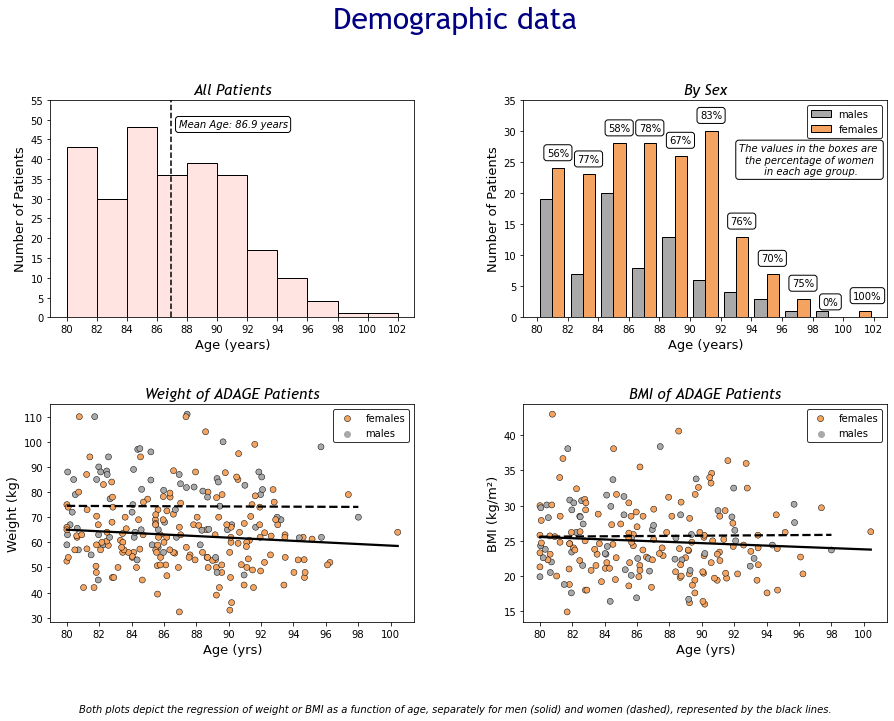

In [6]:
fig1, ax1 = plt.subplots(nrows = 2, ncols = 2, figsize = (15,10))
fig1.suptitle('Demographic data', fontdict = fontdict_title, fontsize = fontsize_title)
fig1.patch.set_facecolor('white')
fig1.subplots_adjust(top=0.85)
plt.subplots_adjust(hspace=0.4, wspace=0.3)

#Age distribution of ADAGE patients

bins_age = range(int(patients.age.min()), int(patients.age.max()) + 4, 2)

ax1[0,0].hist(patients.age,
              bins = bins_age,
              color = 'mistyrose',
              edgecolor = 'black')

ax1[0,0].axvline(x = np.mean(patients['age']),
                 color = 'black',
                 linestyle = '--')

ax1[0,0].text(np.mean(patients['age'])+0.5, 0.8*(np.max(ax1[0,0].get_yticks())), f"Mean Age: {np.mean(patients['age']):.1f} years",
             fontdict= fontdict_addinfo, bbox = {'facecolor': 'white', 'edgecolor' : 'black', 'boxstyle': 'round'}, ha = 'left') 
    
ax1[0,0].set_xticks(range(int(patients.age.min()), int(patients.age.max())+3,2))
ax1[0,0].set_yticks(range(0, int(np.max(ax1[0, 0].get_yticks())), 5))
ax1[0,0].set_xlabel('Age (years)', fontdict = fontdict_label)
ax1[0,0].set_ylabel('Number of Patients', fontdict = fontdict_label)
ax1[0,0].set_title('All Patients', fontdict = fontdict_subtitle)

#Age distribution by sex

hist_females, _ = np.histogram(patients.age[patients['sex'] == 1], bins = bins_age)
hist_males, _ = np.histogram(patients.age[patients['sex'] == 0], bins = bins_age)

ax1[0,1].hist([patients.age[patients['sex'] == 0], patients.age[patients['sex'] == 1]],
              bins = bins_age, 
              color = [male_color, female_color],
              edgecolor = 'black',
              label = ['males', 'females'])

ax1[0,1].set_yticks(range(0, int(np.max(ax1[0,1].get_yticks())+5), 5))
ax1[0,1].set_xticks(range(int(patients.age.min()), int(patients.age.max()) + 4,2))
ax1[0,1].legend(edgecolor = 'black')

ax1[0,1].set_xlabel('Age (years)', fontdict = fontdict_label)
ax1[0,1].set_ylabel('Number of Patients', fontdict = fontdict_label)
ax1[0,1].set_title('By Sex', fontdict = fontdict_subtitle)

#Adding a box with the % of females per bin on top of each bar
ax1[0,1].text(97.8, 23, 'The values in the boxes are \nthe percentage of women\n in each age group.', fontdict= fontdict_addinfo, bbox = {'facecolor' : 'white', 'edgecolor' : 'black', 'boxstyle' : 'round'}, ha='center')

x_0 = 80.65
for n_fem, n_mal in zip(hist_females, hist_males):
    ax1[0,1].text(x_0, (n_fem+2), f'{100*n_fem/(n_fem+n_mal):0.0f}%', bbox = {'facecolor' : 'white', 'edgecolor' : 'black', 'boxstyle' : 'round'})
    x_0 += 2

#Weight as a function of age

sns.scatterplot(x = 'age',
                y = 'weight', 
                data = patients,
                hue = 'sex',
                label = [],
                palette = [male_color, female_color], 
                edgecolor = 'black', 
                ax = ax1[1,0])

sns.regplot(x='age',
            y='weight', 
            data=patients[patients['sex'] == 1],
            scatter=False, 
            ci = None,
            color = 'black', 
            ax = ax1[1,0])

sns.regplot(x='age',
            y='weight', 
            data=patients[patients['sex'] == 0], 
            scatter=False,
            ci = None, 
            color = 'black',
            line_kws = {'linestyle' : '--'}, 
            ax = ax1[1,0])


ax1[1,0].set_ylabel('Weight (kg)', fontdict = fontdict_label)
ax1[1,0].set_xlabel('Age (yrs)', fontdict = fontdict_label)
ax1[1,0].set_xticks(range(int(min(patients.age)), int(max(patients.age)+2), 2))
ax1[1,0].legend(labels = ['females', 'males'], edgecolor = 'black')
ax1[1,0].set_title('Weight of ADAGE Patients', fontdict = fontdict_subtitle)

#BMI as a function of age

sns.scatterplot(x = 'age', 
                y = 'bmi', 
                data = patients, 
                hue = 'sex', 
                label = [], 
                palette = [male_color, female_color], 
                edgecolor = 'black', 
                ax = ax1[1,1])

sns.regplot(x='age', 
            y='bmi',
            data=patients[patients['sex'] == 1],
            scatter=False,
            ci = None,
            color = 'black',
            ax = ax1[1,1])

sns.regplot(x='age', 
            y='bmi', 
            data=patients[patients['sex'] == 0],
            scatter=False, 
            ci = None, 
            color = 'black', 
            line_kws = {'linestyle' : '--'}, 
            ax = ax1[1,1])

ax1[1,1].set_ylabel('BMI (kg/m²)', fontdict = fontdict_label)
ax1[1,1].set_xlabel('Age (yrs)', fontdict = fontdict_label)
ax1[1,1].set_xticks(range(int(min(patients.age)), int(max(patients.age)+2), 2))
ax1[1,1].legend(labels = ['females', 'males'], edgecolor = 'black')
ax1[1,1].set_title('BMI of ADAGE Patients', fontdict = fontdict_subtitle)

fig1.text(0.5, 0, 'Both plots depict the regression of weight or BMI as a function of age, separately for men (solid) and women (dashed), represented by the black lines.',
         fontdict = fontdict_addinfo, ha = 'center')
plt.show()
fig1.savefig('demographics.png')

#Comparative analysis
patients2 = patients[['age', 'sex']].dropna()
mwu_age_sex, pval_age_sex = mannwhitneyu(patients2[patients2['sex'] == 1].age, patients2[patients2['sex'] == 0].age)

mwu_weight_sex, pval_weight_sex = mannwhitneyu(patients[patients['sex'] == 0].weight.dropna(), patients[patients['sex'] == 1].weight.dropna())
mwu_bmi_sex, pval_bmi_sex = mannwhitneyu(patients[patients['sex'] == 0].bmi.dropna(), patients[patients['sex'] == 1].bmi.dropna())


display(HTML(f"""
<div class = 'all'>
    <p>
    Study principal investigators recruited a total of <b>{len(patients)}</b> patients. The mean age of the patients was 
    <b>{np.mean(patients.age):.1f}</b> ± {np.std(patients.age):.1f} years 
    (min-max: <b>{np.min(patients.age):.1f}</b> - <b>{np.max(patients.age):.1f}</b> years)
    and the majority of patients (<b>{patients.sex.value_counts()[1]/len(patients):.1%}</b>) were females, 
    which is expected in this population. Females were {round(patients[patients['sex'] == 1]['age'].mean() - patients[patients['sex'] == 0]['age'].mean(),1)}
    years older than men on average ({pval_txt(pval_age_sex)}).
    </p>
    <p>
    The average weight and BMI of <span class = 'small-caps'>Adage</span> patients were of <b>{np.mean(patients.weight):.1f}</b> ± {np.std(patients.weight):.1f} kg 
    and <b>{np.mean(patients.bmi):.1f}</b> ± {np.std(patients.bmi):.1f} kg/m², respectively.
    The weight of the patients ranged from <b>{np.min(patients.weight):.1f}</b> to <b>{np.max(patients.weight):.1f}</b> kg and it was found to be correlated with sex.
    Men had an average weight that was <b>{np.mean(patients[patients['sex'] == 0]['weight']) - np.mean(patients[patients['sex'] == 1]['weight']):.1f}</b> kg heavier than women ({pval_txt(pval_weight_sex)}). On the other hand, the BMI was 
    not found to be influenced by sex ({pval_txt(pval_bmi_sex)}).
    </p>
</div>
"""))



<h1>Clinical Data</h1>

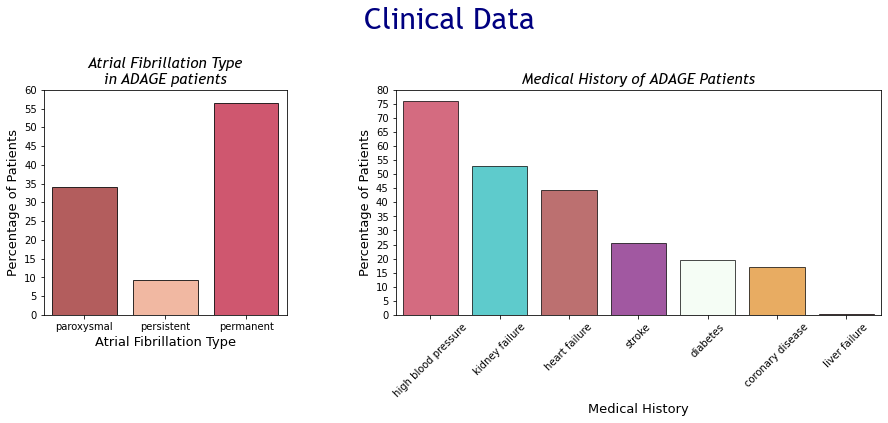

,CHA2DS2VASc,HEMORR2HAGES,HAS-BLED,CIRS-G
mean ± std,5.0 ± 1.4,2.3 ± 1.0,1.6 ± 0.7,10.3 ± 4.4
median (IQR),5 (4 - 6),2 (2 - 3),1 (1 - 2),10 (7 - 12)
min - max,2 - 9,1 - 6,0 - 4,3 - 27


In [7]:
fig3, (ax3_1, ax3_2) = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 5), gridspec_kw = {'width_ratios' : [1,2]})
fig3.suptitle('Clinical Data', fontdict = fontdict_title, fontsize = fontsize_title)
fig3.subplots_adjust(top=0.75)
plt.subplots_adjust(hspace=0.5, wspace=0.3)
fig3.patch.set_facecolor('white')

#AF types
   
sns.barplot(x = patients.fa_type.value_counts(normalize = True).index, 
            y = patients.fa_type.value_counts(normalize = True).values*100, 
            palette = {'paroxysmal': 'firebrick', 'persistent': 'lightsalmon', 'permanent': 'crimson'}, 
            order = ['paroxysmal', 'persistent', 'permanent'], 
            alpha = 0.8, 
            edgecolor = 'black', 
            ax = ax3_1)

ax3_1.set_yticks(range(0, int(np.max(ax3_1.get_yticks())+5),5))
ax3_1.set_xlabel('Atrial Fibrillation Type', fontdict = fontdict_label)
ax3_1.set_ylabel('Percentage of Patients', fontdict = fontdict_label)
ax3_1.set_title('Atrial Fibrillation Type\nin ADAGE patients', fontdict = fontdict_subtitle)

#Medical history of ADAGE patients
    #Creating a df that stores medical history data as % of patients

prevalences = patients[['heartf', 'liverf','coronary', 'stroke', 'diabetes', 'high_bp', 'kidneyf_50']].mean().sort_values(ascending = False)*100

sns.barplot(x = prevalences.index,
            y = prevalences.values,  
            edgecolor = 'black',
            palette = ['crimson', 'darkturquoise', 'firebrick', 'darkmagenta', 'honeydew', 'darkorange', 'maroon'], 
            alpha = 0.7,
            ax = ax3_2)

ax3_2.set_yticks(range(0, int(np.max(ax3_2.get_yticks()+5)), 5))
ax3_2.set_xticks(ticks = ax3_2.get_xticks(), labels = ['high blood pressure','kidney failure','heart failure', 'stroke', 'diabetes', 'coronary disease','liver failure'], rotation = 45)
ax3_2.set_ylabel('Percentage of Patients', fontdict = fontdict_label)
ax3_2.set_xlabel('Medical History', fontdict = fontdict_label)
ax3_2.set_title('Medical History of ADAGE Patients', fontdict = fontdict_subtitle)

fig3.savefig('clinical.png')
plt.show()

display(HTML(f'''
<div class = 'all'>
    <p>All patients included in the cohort suffered from atrial fibrillation as it was a mandatory inclusion criterion.
    Among the patients, <b>{patients.fa_type.value_counts(normalize=True)['permanent']:.1%}</b> were 
    diagnosed with permanent AF, while <b>{patients.fa_type.value_counts(normalize=True)['paroxysmal']:.1%}</b>
    were diagnosed with paroxysmal AF. Only <b>{patients.fa_type.value_counts(normalize=True)['persistent']:.1%}</b>
    were diagnosed with persistent AF. In terms of medical history, <span class = 'small-caps'>Adage</span> patients
    were found to have multiple medical conditions with an average CIRS-G score of <b>{np.mean(patients.cirsg_tot):.1f}</b>. 
    The most prevalent associated pathologies were hypertension (<b>{patients['high_bp'].value_counts(normalize = True)[1]:.1%}</b>),
    kidney failure (glomerular filtration rate < 50 mL/min according to Cockcroft formula - 
    <b>{patients['kidneyf_50'].value_counts(normalize = True)[1]:.1%}</b>)
    and heart failure (<b>{patients['heartf'].value_counts(normalize = True)[1]:.1%}</b>).
    It is noteworthy that quarter of patients had an history of stroke and the mean CHA2DS2VASc score 
    was <b>{np.mean(patients.chadsvasc_score):.1f}</b> ± {np.std(patients.chadsvasc_score):.1f}. The table below provides details about 
    clinical scores.</p>
</div>

<table>
    <caption>Clinical scores</caption>
        <thead>
            <tr>
                <th></th>
                <th>CHA2DS2VASc</th>
                <th>HEMORR2HAGES</th>
                <th>HAS-BLED</th>
                <th>CIRS-G</th>
            </tr>
        </thead>
        <tbody>
            <tr>
                <td>mean ± std</td>
                <td>{np.mean(patients.chadsvasc_score):.1f} ± {np.std(patients.chadsvasc_score):.1f}</td>
                <td>{np.mean(patients.hemorrhages_score):.1f} ± {np.std(patients.hemorrhages_score):.1f}</td>
                <td>{np.mean(patients.hasbled_score):.1f} ± {np.std(patients.hasbled_score):.1f}</td>
                <td>{np.mean(patients.cirsg_tot):.1f} ± {np.std(patients.cirsg_tot):.1f}</td>
            </tr>
            <tr>
                <td>median (IQR)</td>
                <td>{np.median(patients.chadsvasc_score.dropna()):.0f} ({np.percentile(patients.chadsvasc_score.dropna(), 25):.0f} - {np.percentile(patients.chadsvasc_score.dropna(), 75):.0f})</td>
                <td>{np.median(patients.hemorrhages_score.dropna()):.0f} ({np.percentile(patients.hemorrhages_score.dropna(), 25):.0f} - {np.percentile(patients.hemorrhages_score.dropna(), 75):.0f})</td>
                <td>{np.median(patients.hasbled_score.dropna()):.0f} ({np.percentile(patients.hasbled_score.dropna(), 25):.0f} - {np.percentile(patients.hasbled_score.dropna(), 75):.0f})</td>
                <td>{np.median(patients.cirsg_tot.dropna()):.0f} ({np.percentile(patients.cirsg_tot.dropna(), 25):.0f} - {np.percentile(patients.cirsg_tot.dropna(), 75):.0f})</td>
            </tr>
            <tr>
                <td>min - max</td>
                <td>{np.min(patients.chadsvasc_score):.0f} - {np.max(patients.chadsvasc_score):.0f}</td>
                <td>{np.min(patients.hemorrhages_score):.0f} - {np.max(patients.hemorrhages_score):.0f}</td>
                <td>{np.min(patients.hasbled_score):.0f} - {np.max(patients.hasbled_score):.0f}</td>
                <td>{np.min(patients.cirsg_tot):.0f} - {np.max(patients.cirsg_tot):.0f}</td>
            </tr>
        </tbody>
</table>      
'''))

<h1>Laboratory Data</h1>

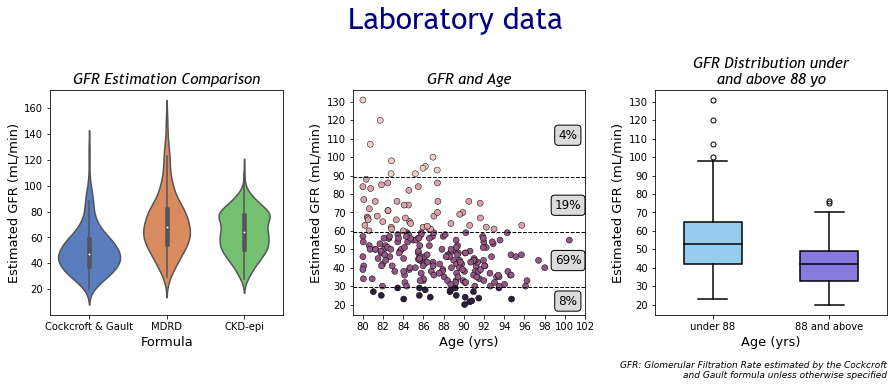

,Haemoglobin (g/dL),Platelets (G/L),Leucocytes (G/L),Fibrinogen (g/L),Albumin (g/L),Creatinine (µmol/L)
mean ± SD,12.1 ± 1.7,254.8 ± 92.7,8.2 ± 3.2,4.0 ± 1.0,33.1 ± 5.2,82.7 ± 24.4
median(IQR),12.2(11.1 - 13.3),238.0(193.0 - 291.0),7.5(6.1 - 9.6),3.9(3.3 - 4.6),33.0(30.0 - 36.6),78.0(65.0 - 99.0)
min - max,8.0 - 16.3,93.0 - 770.0,3.2 - 23.1,2.0 - 7.5,18.9 - 46.0,36.0 - 190.0


In [8]:
fig4, ax4 = plt.subplots(nrows = 1, ncols = 3, figsize = (15,5), gridspec_kw={'width_ratios': [1, 1, 1]})
fig4.suptitle('Laboratory data', fontdict = fontdict_title, fontsize = fontsize_title)
fig4.subplots_adjust(top=0.75)
plt.subplots_adjust(hspace=0.5, wspace=0.3)
fig4.patch.set_facecolor('white')

#Comparing ClCr formulae
sns.violinplot(data=patients[['clcr_cockcroft', 'clcr_mdrd', 'clcr_ckdepi']],
               palette='muted',
               inner='box',
               ax = ax4[0])

ax4[0].set_xticks(ax4[0].get_xticks(), ['Cockcroft & Gault', 'MDRD', 'CKD-epi'])
ax4[0].set_xlabel('Formula', fontdict = fontdict_label)
ax4[0].set_ylabel('Estimated GFR (mL/min)', fontdict = fontdict_label)
ax4[0].set_title('GFR Estimation Comparison', fontdict = fontdict_subtitle)

#ClCr as a function of age
sns.scatterplot(x = 'age', 
                y = 'clcr_cockcroft',
                data = patients, 
                hue = 'kidneyf_class', 
                palette = [[0.931, 0.820, 0.797],[0.855, 0.641, 0.675], [0.579, 0.339, 0.521], [0.175, 0.118, 0.242]], 
                edgecolor = 'black',
                legend = False, 
                ax = ax4[1])

ax4[1].axhline(y = 89.5,
               linewidth = 1,
               linestyle = 'dashed',
               color = 'black')

ax4[1].axhline(y = 59.5,
               linewidth = 1,
               linestyle = 'dashed', 
               color = 'black')

ax4[1].axhline(y = 29.5, 
               linewidth = 1, 
               linestyle = 'dashed',
               color = 'black')

ax4[1].set_xticks(range(int(patients.age.min()), int(patients.age.max()+3), 2))
ax4[1].set_xlabel('Age (yrs)', fontdict = fontdict_label)
ax4[1].set_yticks(range(int(patients.clcr_cockcroft.min()), int(patients.clcr_cockcroft.max()), 10))
ax4[1].set_ylabel('Estimated GFR (mL/min)', fontdict = fontdict_label)
ax4[1].set_title('GFR and Age', fontdict = fontdict_subtitle)

    #Adding a box with the % of patient in each kidney failure class
ax4[1].text(99.35, 110, f'{patients.kidneyf_class.value_counts(normalize = True)["normal"]:.0%}', size = 12, bbox = {'facecolor' : 'gainsboro', 'edgecolor' : 'black', 'boxstyle' : 'round'})
ax4[1].text(99, 72, f'{patients.kidneyf_class.value_counts(normalize = True)["mildly decreased"]:.0%}', size = 12, bbox = {'facecolor' : 'gainsboro', 'edgecolor' : 'black', 'boxstyle' : 'round'})
ax4[1].text(99, 42, f'{patients.kidneyf_class.value_counts(normalize = True)["moderately decreased"]:.0%}', size = 12, bbox = {'facecolor' : 'gainsboro', 'edgecolor' : 'black', 'boxstyle' : 'round'})
ax4[1].text(99.35, 20, f'{patients.kidneyf_class.value_counts(normalize = True)["severely decreased"]:.0%}', size = 12, bbox = {'facecolor' : 'gainsboro', 'edgecolor' : 'black', 'boxstyle' : 'round'})

#ClCr distribution with age cut-off of 88
patients['cutoff_clcr'] = patients['age'].apply(lambda x: 0 if x < 88 else 1)
sns.boxplot(y = 'clcr_cockcroft',
            x = 'cutoff_clcr',
            data = patients, 
            ax = ax4[2],
            width = 0.5,
            palette = ['lightskyblue', 'mediumslateblue'], 
            boxprops = {'edgecolor': 'black'}, 
            whiskerprops = {'color' : 'black'}, 
            medianprops = {'color' : 'black'}, 
            capprops={'color': 'black'}, 
            flierprops = {'marker' : 'o', 'markerfacecolor' : 'None', 'markeredgecolor' : 'black'})

ax4[2].set_xticks(ticks = ax4[2].get_xticks(), labels = ['under 88', '88 and above'])
ax4[2].set_xlabel('Age (yrs)', fontdict = fontdict_label)
ax4[2].set_yticks(range(int(patients.clcr_cockcroft.min()), int(patients.clcr_cockcroft.max())+9, 10))
ax4[2].set_ylabel('Estimated GFR (mL/min)', fontdict = fontdict_label)
ax4[2].set_title('GFR Distribution under\nand above 88 yo', fontdict = fontdict_subtitle)

fig4.text(0.9, -0.05, 'GFR: Glomerular Filtration Rate estimated by the Cockcroft\nand Gault formula unless otherwise specified', fontdict = {'fontstyle' : 'italic', 'fontsize' : 9}, ha='right')

plt.savefig('labs.png')
plt.show()

wil_cockcroft_mdrd, pval_cockcroft_mdrd = wilcoxon(patients[['clcr_cockcroft', 'clcr_mdrd']].dropna()['clcr_mdrd'],
                                                   patients[['clcr_cockcroft', 'clcr_mdrd']].dropna()['clcr_cockcroft'])

wil_cockcroft_ckd, pval_cockcroft_ckd = wilcoxon(patients[['clcr_cockcroft', 'clcr_ckdepi']].dropna()['clcr_ckdepi'],
                                                 patients[['clcr_cockcroft', 'clcr_ckdepi']].dropna()['clcr_cockcroft'])

corr_cockcroft_age, pval_cockcroft_age = spearmanr(patients[['clcr_cockcroft', 'age']].dropna()['clcr_cockcroft'],
                                                   patients[['clcr_cockcroft', 'age']].dropna()['age'])

display(HTML(f'''
<div class = 'all'>
    <p>In this study, GFR (glomerular filtration rate) was assessed using three different formulae: Cockcroft & Gault, 
    MDRD and CKD-epi. While some correlations were observed between all three methods, significant differences were found 
    in the estimated GFR. On average, compared to the Cockcroft formula, the estimated GFR was 
    <b>{np.mean(patients.clcr_mdrd)-np.mean(patients.clcr_cockcroft):.1f}</b> mL/min and
    <b>{np.mean(patients.clcr_ckdepi)-np.mean(patients.clcr_cockcroft):.1f}</b> mL/min higher using MDRD 
    ({pval_txt(pval_cockcroft_mdrd)}) and CKD-epi ({pval_txt(pval_cockcroft_ckd)}), respectively. It is known that both 
    MDRD and CKD-epi tend to overestimate GFR in elderly people. Therefore, the Cockcroft & Gault formula was chosen as 
    the gold standard to estimate GFR in <span style = "font-variant: small-caps;">Adage</span> patients. The mean GFR 
    was of <b>{np.mean(patients.clcr_cockcroft):.1f}</b> ± {np.std(patients.clcr_cockcroft):.1f} mL/min. GFR was found to be 
    negatively correlated with age ({pval_txt(pval_cockcroft_age)}). Remarkably, the maximum GFR observed in patients 
    aged 88 years and above was <b>{patients[patients['age']>=88]['clcr_cockcroft'].max():.1f}</b> mL/min 
    (mean: <b>{np.mean(patients[patients['age']>=88]['clcr_cockcroft']):.1f}</b> mL/min).</p>
</div>
'''))
 

display(HTML(f'''
<table>
<caption>Other laboratory results</caption>
    <head>
        <thead>
            <tr>
                <th></th>
                <th>Haemoglobin (g/dL)</th>
                <th>Platelets (G/L)</th>
                <th>Leucocytes (G/L)</th>
                <th>Fibrinogen (g/L)</th>
                <th>Albumin (g/L)</th>
                <th>Creatinine (µmol/L)</th>
            </tr>
        </thead>
        <tbody>
            <tr>
                <td>mean ± SD</td>
                <td>{mean_sd(patients, 'hb')}</td>
                <td>{mean_sd(patients, 'platelets')}</td>
                <td>{mean_sd(patients, 'leucocytes')}</td>
                <td>{mean_sd(patients, 'fib')}</td>
                <td>{mean_sd(patients, 'albumin')}</td>
                <td>{mean_sd(patients, 'creat')}</td>
            </tr>
            <tr>
                <td>median<br>(IQR)</td>
                <td>{median_iqr(patients, 'hb')}</td>
                <td>{median_iqr(patients, 'platelets')}</td>
                <td>{median_iqr(patients, 'leucocytes')}</td>
                <td>{median_iqr(patients, 'fib')}</td>
                <td>{median_iqr(patients, 'albumin')}</td>
                <td>{median_iqr(patients, 'creat')}</td>
            </tr>
            <tr>
                <td>min - max</td>
                <td>{min_max(patients, 'hb')}</td>
                <td>{min_max(patients, 'platelets')}</td>
                <td>{min_max(patients, 'leucocytes')}</td>
                <td>{min_max(patients, 'fib')}</td>
                <td>{min_max(patients, 'albumin')}</td>
                <td>{min_max(patients, 'creat')}</td>
            </tr>
        </tbody>
</table>
'''))

<h1>Medications Data</h1>

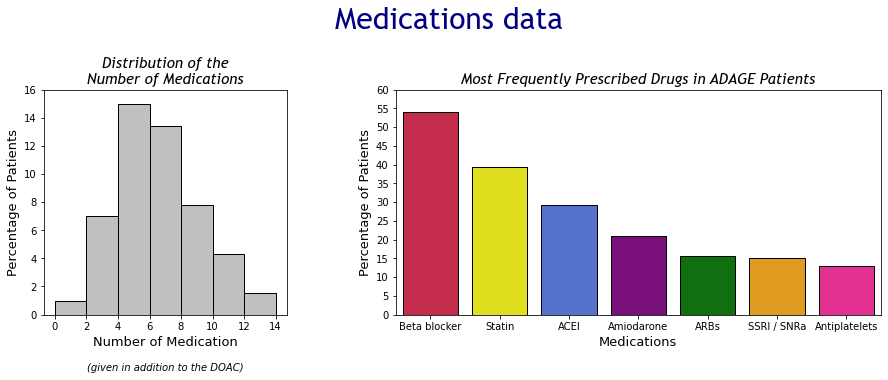

In [9]:
fig5, (ax5_1, ax5_2) = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5), gridspec_kw = {'width_ratios' : [1,2]})
fig5.suptitle('Medications data', fontdict = fontdict_title, fontsize = fontsize_title)
fig5.subplots_adjust(top=0.75)
plt.subplots_adjust(hspace=0.5, wspace=0.3)
fig5.patch.set_facecolor('white')

#Number of medication
ax5_1.hist(patients['nb_medications'].dropna(),
           density = True,
           bins = 7,
           color = 'silver',
           edgecolor = 'black')

ax5_1.set_yticks(ticks = [x/100 for x in range(0, int(np.max(ax5_1.get_yticks()*100)+2),2)],
                 labels = range(0, int(np.max(ax5_1.get_yticks()*100)+2),2))
ax5_1.set_ylabel('Percentage of Patients', fontdict = fontdict_label)
ax5_1.set_xlabel('Number of Medication', fontdict = fontdict_label)
ax5_1.set_title('Distribution of the\nNumber of Medications', fontdict = fontdict_subtitle)
ax5_1.text(7, -0.04, '(given in addition to the DOAC)', fontdict = fontdict_addinfo, ha = 'center')

#Therapeutical classes in the cohort

med_values = []
med_names = ['Amiodarone', 'Beta blocker', 'ACEI', 'ARBs', 'Statin', 'Antiplatelets', 'SSRI or SNRA']
for medication in ['amiodarone', 'bblocker', 'acei', 'arbs', 'statin', 'any_anti_plt', 'ssri_snra']:
    med_values.append(patients[medication].value_counts(normalize = True)[1.0])

med_df = pd.DataFrame({'medications' : med_names, 'val' : med_values})
med_df = med_df.sort_values('val', ascending = False)

sns.barplot(x = patients[['amiodarone', 'bblocker', 'acei', 'arbs', 'statin', 'any_anti_plt', 'ssri_snra']].mean().sort_values(ascending = False).index,
            y = patients[['amiodarone', 'bblocker', 'acei', 'arbs', 'statin', 'any_anti_plt', 'ssri_snra']].mean().sort_values(ascending = False).values,
            ax = ax5_2,
            palette = {'amiodarone' : 'darkmagenta', 
                       'bblocker' : 'crimson', 
                       'statin' : 'yellow', 
                       'any_anti_plt' : 'deeppink', 
                       'acei' : 'royalblue', 
                       'arbs' : 'green', 
                       'ssri_snra' : 'orange' },
            edgecolor = 'black')

ax5_2.set_yticks(ticks = [x/100 for x in range(0, int(np.max(ax5_2.get_yticks())*100+5),5)],
                 labels = [x for x in range(0, int(np.max(ax5_2.get_yticks())*100+5),5)])

ticklabels_fig5 = {'amiodarone': 'Amiodarone',
                           'bblocker': 'Beta blocker',
                           'acei' : 'ACEI',
                           'arbs' : 'ARBs',
                           'statin': 'Statin',
                           'any_anti_plt': 'Antiplatelets',
                           'ssri_snra': 'SSRI / SNRa'}

ax5_2.set_xticks(ticks = ax5_2.get_xticks(),
                 labels = [ticklabels_fig5.get(tick) for tick in patients[['amiodarone', 'bblocker', 'acei', 'arbs', 'statin', 'any_anti_plt', 'ssri_snra']].mean().sort_values(ascending = False).index])

ax5_2.set_ylabel('Percentage of Patients', fontdict = fontdict_label) 
ax5_2.set_xlabel('Medications', fontdict = fontdict_label)
ax5_2.set_title('Most Frequently Prescribed Drugs in ADAGE Patients', fontdict = fontdict_subtitle)

plt.savefig('medications.png')
plt.show()

display(HTML(f'''
<div class = 'all'>
    <p>In the <span class = 'small-caps'>Adage</span> cohort, patients were taking an average of <b>{patients.nb_medications.mean():.1f}</b>
medications per day along with their DOAC. Among the medications prescribed, beta-blockers (<b>{patients.bblocker.value_counts(normalize = True)[1.0]:.1%}</b>) and statins (<b>{patients.statin.value_counts(normalize = True)[1.0]:.1%}</b>) were the most commonly used.
Additionally, </b>{patients.amiodarone.value_counts(normalize = True)[1.0]:.1%}</b> of the cohort was treated with amiodarone, while the use of other antiarrhythmic drugs was negligible.
A minority (<b>{patients.any_anti_plt.value_counts(normalize = True)[1.0]:.1%}</b>) of patients was treated with an antiplatelet agent, with the majority 
(<b>{patients[patients['any_anti_plt'] == 1.0].aspirin.value_counts(normalize = True)[1.0]:.1%}</b>) of them receiving aspirin.</p>
</div>
'''))


<h1>Trends in Medication Prescriptions</h1>

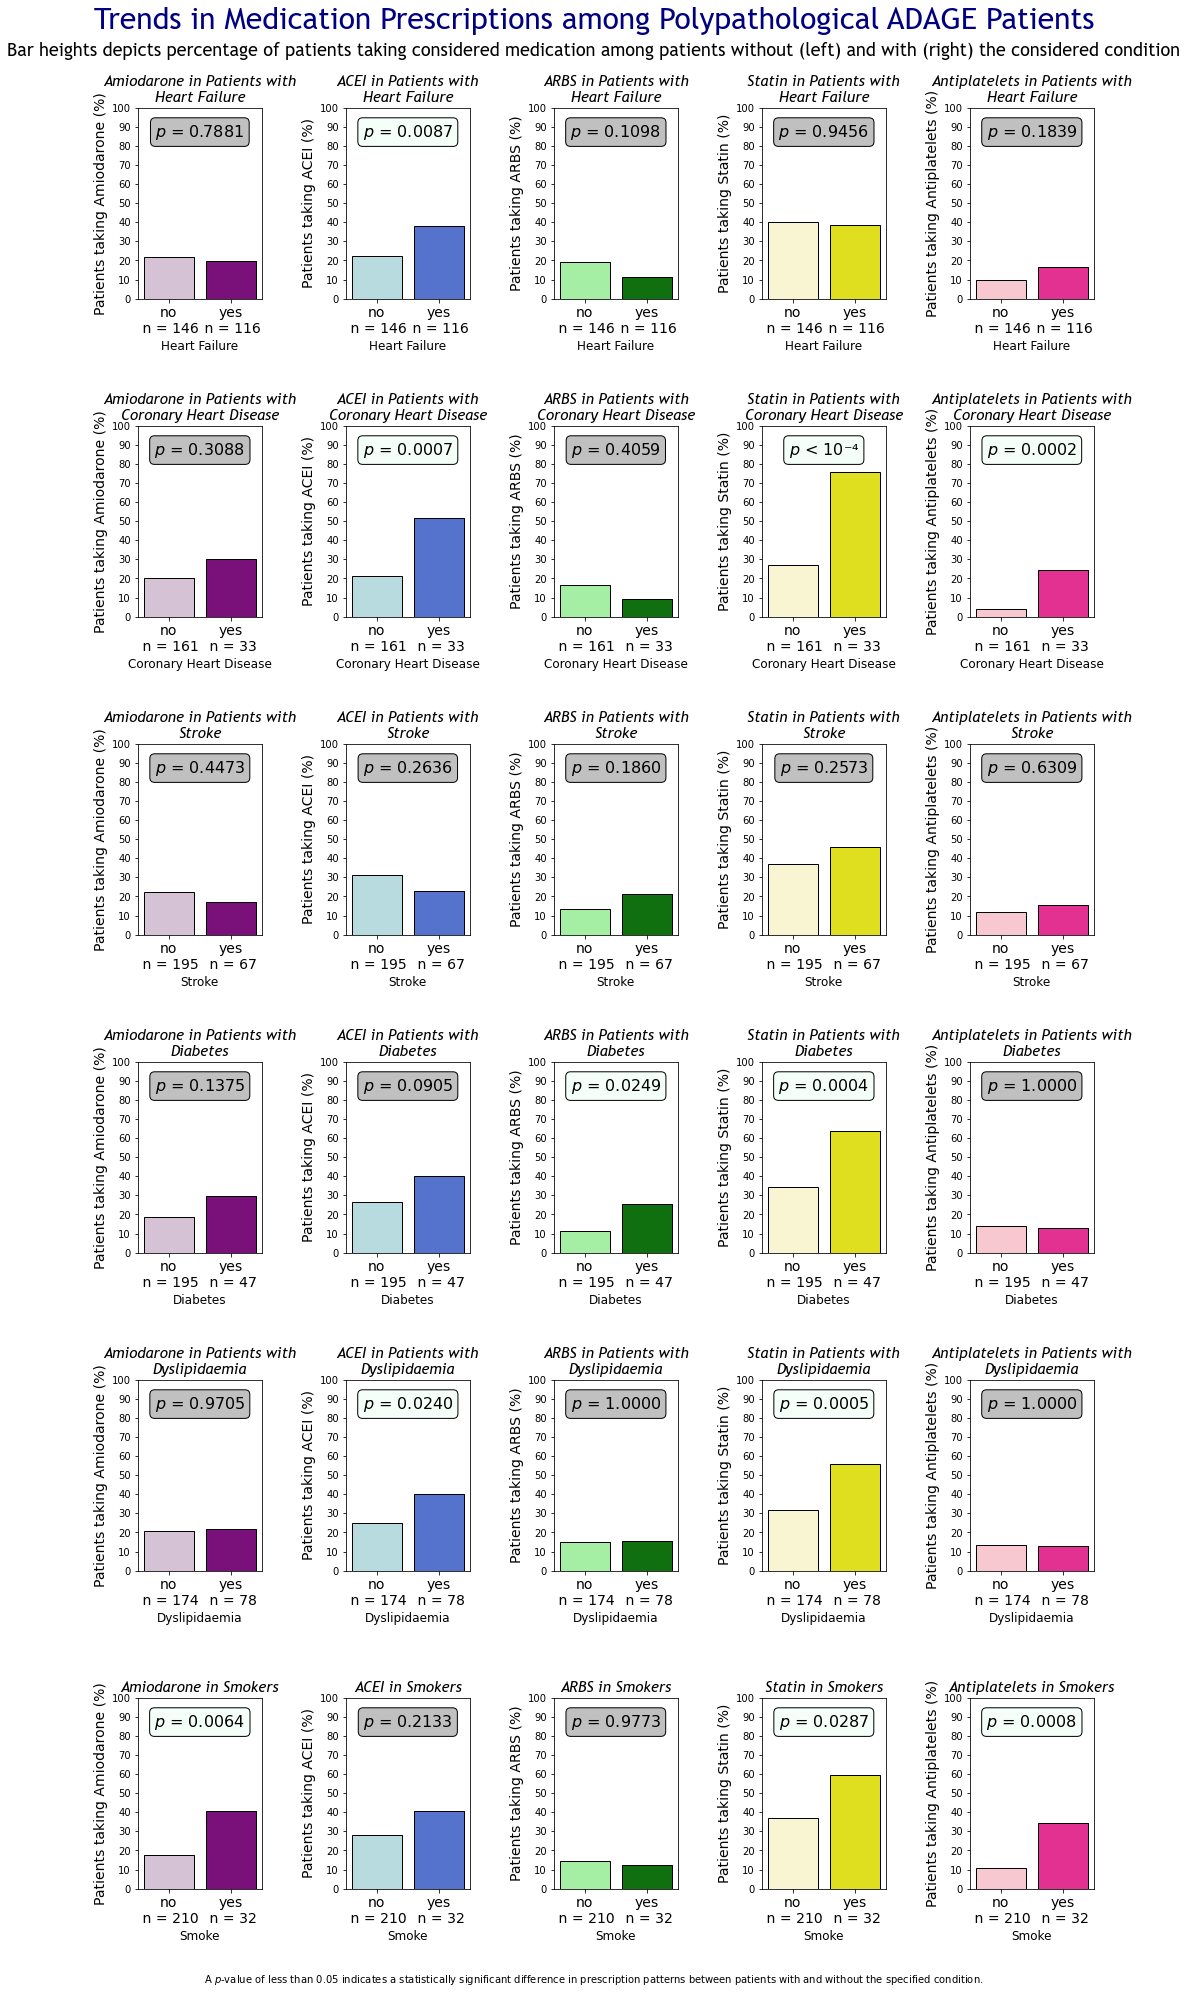

In [10]:
lst_patho = ['heartf', 'coronary', 'stroke', 'diabetes', 'dyslipidaemia', 'smoke']

patho_titles = {'heartf' : 'Heart Failure',
                'coronary' : 'Coronary Heart Disease',
                'stroke' : 'Stroke',
                'diabetes' : 'Diabetes',
                'dyslipidaemia' : 'Dyslipidaemia',
                'smoke' : 'Smoke',
                'obesity' : 'Obesity'}

lst_medic = ['amiodarone', 'acei', 'arbs', 'statin', 'any_anti_plt']
medic_titles = {'amiodarone' : ['Amiodarone', 'thistle' ,'darkmagenta'], 
                'acei' : ['ACEI', 'powderblue', 'royalblue'],
                'arbs' : ['ARBS','palegreen', 'green'],
                'statin' : ['Statin', 'lemonchiffon', 'yellow'],
                'any_anti_plt' : ['Antiplatelets', 'pink', 'deeppink']}

fig6, ax6 = plt.subplots(nrows = len(lst_patho), ncols = len(lst_medic), figsize = (15, 28))
fig6.suptitle('Trends in Medication Prescriptions among Polypathological ADAGE Patients', fontdict = fontdict_title, fontsize = fontsize_title)
fig6.text(0.5, 0.956, 'Bar heights depicts percentage of patients taking considered medication among patients without (left) and with (right) the considered condition', ha = 'center', fontdict = {'color' : 'black','family' : 'Trebuchet MS'}, fontsize = 0.6*fontsize_title)

fig6.patch.set_facecolor('white')

#plots are built by looping into the list of considered clinical states; and for each state, by looping into a list of considered medications
for patho in lst_patho:
    for medic in lst_medic:
        
        #Chi2 testing to look for association between a clinical state and a medication
        chi2_ij, pval_ij, dof, expected = chi2_contingency(pd.crosstab(patients[[patho, medic]].dropna()[patho], patients[[patho, medic]].dropna()[medic]))
        
        sns.barplot(x = patho,
                    y = medic,
                    data = patients[[patho, medic]].dropna(),
                    ax = ax6[lst_patho.index(patho), lst_medic.index(medic)],
                    ci = None,
                    palette = [medic_titles[medic][1], medic_titles[medic][2]],
                    edgecolor = 'black')
        
        ax6[lst_patho.index(patho), lst_medic.index(medic)].set_yticks([x/100 for x in range(0,101,10)])
        ax6[lst_patho.index(patho), lst_medic.index(medic)].set_yticklabels(range(0,101,10))
        ax6[lst_patho.index(patho), lst_medic.index(medic)].set_xticklabels([f'no\n n = {len(patients[patients[patho] == 0.0])}', f'yes\n n = {len(patients[patients[patho] == 1.0])}'], size = 14)
        ax6[lst_patho.index(patho), lst_medic.index(medic)].set_ylabel(f'Patients taking {medic_titles[medic][0]} (%)', size = 14)
        ax6[lst_patho.index(patho), lst_medic.index(medic)].set_xlabel(patho_titles[patho], size = 12)
        if patho == 'smoke': #title shall be formulated differentely for smoking
            ax6[lst_patho.index(patho), lst_medic.index(medic)].set_title(f'{medic_titles[medic][0]} in Smokers', fontdict = fontdict_subtitle)
        else:
            ax6[lst_patho.index(patho), lst_medic.index(medic)].set_title(f'{medic_titles[medic][0]} in Patients with\n{patho_titles[patho]}', fontdict = fontdict_subtitle)
        if pval_ij <0.05:
            ax6[lst_patho.index(patho), lst_medic.index(medic)].text(0.5, 0.85,'{}'.format(pval_txt(pval_ij)), fontsize = 16, bbox = {'facecolor' : 'mintcream', 'edgecolor' : 'black', 'boxstyle' : 'round'}, ha = 'center')
        else:
            ax6[lst_patho.index(patho), lst_medic.index(medic)].text(0.5, 0.85,'{}'.format(pval_txt(pval_ij)), fontsize = 16, bbox = {'facecolor' : 'silver', 'edgecolor' : 'black', 'boxstyle' : 'round'}, ha = 'center')


fig6.text(0.5, 0.0, "A $\mathit{{p}}$-value of less than 0.05 indicates a statistically significant difference in prescription patterns between patients with and without the specified condition.", size = 10, ha = 'center')
fig6.tight_layout(pad = 4)

fig6.savefig('patho_medic_chi2')
plt.show()

display(HTML(f'''
<div class = 'all'>
    <p>When comparing the prescription frequencies of certain medications among patients with different comorbidities, some trends could be identified:</p>
<ul>
    <li>Patients with a history of coronary heart disease were found to have a significant prescription rate of <b>statins</b> ({pval_txt(chi2_pm('coronary', 'statin'))}),
    <b>antiplatelets</b> ({pval_txt(chi2_pm('coronary', 'any_anti_plt'))}), and <b>ACEI</b> ({pval_txt(chi2_pm('coronary', 'acei'))}).
    These medications are indeed commonly prescribed to reduce the risk of cardiovascular events and complications in patients with a history of coronary heart disease.</li>
    <li>Smokers were found to be more likely to receive <b>statins</b> ({pval_txt(chi2_pm('smoke', 'statin'))}) and <b>antiplatelets</b> ({pval_txt(chi2_pm('smoke', 'any_anti_plt'))})
    as compared to non-smokers. Of note, {patients[patients['coronary'] == 1].smoke.value_counts(normalize = True)[1]:.1%} of patients with a history of coronary heart disease
    were found to be smokers. Furthermore, <b>amiodarone</b> was found to be significantly more commonly prescribed in smokers as compared to non-smokers.</li>
    <li>Patients with diabetes showed a significant increase in treatment with <b>ARBs</b> ({pval_txt(chi2_pm('diabetes', 'arbs'))}), a medication class that was not 
    significantly more prescribed in any other subgroup. Additionally, these patients were more likely to receive <b>statin</b> therapy ({pval_txt(chi2_pm('diabetes', 'statin'))}).</li>
    <li>The use of <b>amiodarone</b> was found to be significantly lower among patients with dementia ({pval_txt(chi2_pm('dementia', 'amiodarone'))}).</li>
    <li>Beta blockers were comonly prescribed, regardless of polypathology.</li>
    <li>No discernible pattern in medication prescriptions was noted among patients with a glomerular filtration rate of less than 50 mL/min.</li>
</ul>
</div>
'''))

<h1>Genotypes of patients</h1>

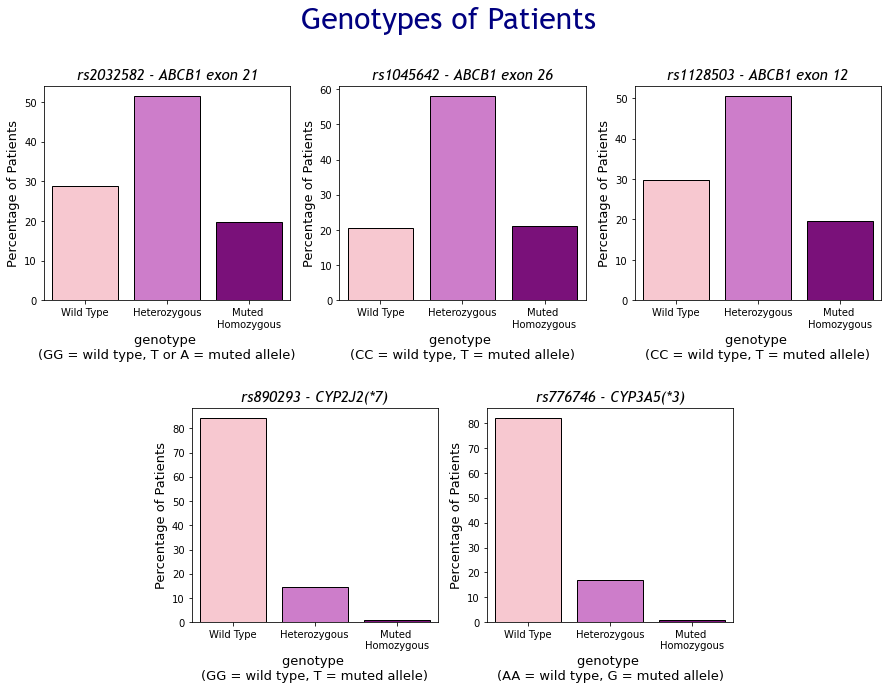

In [11]:
 ##VIZ 7: GENETICS
fig7 = plt.figure(figsize = (15,10))
spec = mpl.gridspec.GridSpec(ncols=6, nrows=2)
subplots = [spec[0,0:2], spec[0,2:4], spec[0,4:], spec[1,1:3], spec[1,3:5]]

fig7.subplots_adjust(top = 0.87)
plt.subplots_adjust(hspace=0.5, wspace=0.5)
fig7.patch.set_facecolor('white')
   
gene_lst = ['encoded_abcb1_21', 'encoded_abcb1_26', 'encoded_abcb1_12', 'encoded_cyp_2j2', 'encoded_cyp_3a5']
gene_dict = {
    'encoded_abcb1_21': ['rs2032582 - ABCB1 exon 21', 'genotype \n(GG = wild type, T or A = muted allele)'],
    'encoded_abcb1_26': ['rs1045642 - ABCB1 exon 26', 'genotype \n(CC = wild type, T = muted allele)'],
    'encoded_abcb1_12': ['rs1128503 - ABCB1 exon 12', 'genotype \n(CC = wild type, T = muted allele)'], 
    'encoded_cyp_2j2': ['rs890293 - CYP2J2(*7)', 'genotype \n(GG = wild type, T = muted allele)'], 
    'encoded_cyp_3a5': ['rs776746 - CYP3A5(*3)', 'genotype \n(AA = wild type, G = muted allele)']
}
i = 0
fig7.suptitle('Genotypes of Patients', fontdict = fontdict_title, fontsize = fontsize_title)

for gene in gene_lst:
    ax = fig7.add_subplot(subplots[i])
    temp_df = pd.DataFrame(patients[gene].value_counts(normalize = True)).sort_index().reset_index().rename(columns={'index': 'genotype'})
    sns.barplot(y = gene, x = 'genotype', data = temp_df, ax = ax, palette = ['pink', 'orchid', 'darkmagenta'], edgecolor = 'black')
    i+=1
    ax.set_xticklabels(['Wild Type', 'Heterozygous', 'Muted \nHomozygous'])
    ax.set_xlabel(gene_dict[gene][1], fontdict = fontdict_label)
    ax.set_yticklabels([int(x*100) for x in ax.get_yticks()])
    ax.set_ylabel('Percentage of Patients', fontdict = fontdict_label)
    ax.set_title(gene_dict[gene][0], fontdict = fontdict_subtitle)

plt.savefig('genetics.png')
plt.show()

display(HTML(f'''
<div class = 'all'>
    <p>The allelic frequency of different variants of <i>ABCB1</i> encoding the P-glycoprotein, 
as well as those of <i>CYP2J2</i> and <i>CYP3A5</i> analysed, does not differ from those reported in the literature for Caucasians 
(source: <a href = 'https://www.pharmgkb.org/'>PharmGKB</a>). None of the studied variants show significant deviation from Hardy-Weinberg equilibrium.</p>
</div>
'''))

<h1>Adage patients characteristics</h1>

In [12]:
males = patients[patients['sex'] == 0]
females = patients[patients['sex'] == 1]

display(HTML(f'''
<table class = 'recap_table'>
<caption><span class = 'small-caps'>Adage</span> Patients Characteristics</caption>
    <head>
        <thead>
            <tr>
                <th></th>
                <th>Females <br> <i>n</i> = {len(females)}</th>
                <th>Males <br> <i>n</i> = {len(males)}</th>
                <th>All Patients<br> <i>n</i> = {len(patients)}</th>
                <th><i>p</i>-value</th>
            </tr>
        </thead>
        <tbody>
            <tr>
                <td colspan = 5 class = 'col_group'>Demographics</td>                
            </tr>
            <tr>
                <td class = 'col_1'>Age - yr</td>
                <td>{mean_sd(females, 'age')}</td>
                <td>{mean_sd(males, 'age')}</td>
                <td>{mean_sd(patients, 'age')}</td>
                <td>{pval_txt_b(mwu_mf('age'))}</td>
            </tr>
            <tr>
                <td class = 'col_1'>Weight - kg</td>
                <td>{mean_sd(females, 'weight')}</td>
                <td>{mean_sd(males, 'weight')}</td>
                <td>{mean_sd(patients, 'weight')}</td>
                <td>{pval_txt_b(mwu_mf('weight'))}</td>
            </tr>
            <tr>
                <td class = 'col_1'>BMI - kg/m²</td>
                <td>{mean_sd(females, 'bmi')}</td>
                <td>{mean_sd(males, 'bmi')}</td>
                <td>{mean_sd(patients, 'bmi')}</td>
                <td>{pval_txt_b(mwu_mf('bmi'))}</td>
            </tr>
            <tr>
                <td colspan = 5 class = 'col_group'>Medical History</td>                
            </tr>
            <tr>
                <td class = 'col_1'>Atrial Fibrillation Type <br><i>Paroxysmal <br>Persistent <br>Permanent</i></td>
                <td><br>{females['fa_type'].value_counts(normalize = True)['paroxysmal']:.1%} 
                    <br>{females['fa_type'].value_counts(normalize = True)['persistent']:.1%}
                    <br>{females['fa_type'].value_counts(normalize = True)['permanent']:.1%}</td>
                <td><br>{males['fa_type'].value_counts(normalize = True)['paroxysmal']:.1%} 
                    <br>{males['fa_type'].value_counts(normalize = True)['persistent']:.1%}
                    <br>{males['fa_type'].value_counts(normalize = True)['permanent']:.1%}</td>
                <td><br>{patients['fa_type'].value_counts(normalize = True)['paroxysmal']:.1%} 
                    <br>{patients['fa_type'].value_counts(normalize = True)['persistent']:.1%}
                    <br>{patients['fa_type'].value_counts(normalize = True)['permanent']:.1%}</td>
                <td>{pval_txt_b(chi2_mf('fa_type'))}</td>
            </tr>
            <tr>
                <td class = 'col_1'>Heart Failure</td>
                <td>{females['heartf'].value_counts(normalize = True)[1]:.1%}</td>
                <td>{males['heartf'].value_counts(normalize = True)[1]:.1%}</td>
                <td>{patients['heartf'].value_counts(normalize = True)[1]:.1%}</td>
                <td>{pval_txt_b(chi2_mf('heartf'))}</td>
            </tr>            
            <tr>
                <td class = 'col_1'>Coronary Disease</td>
                <td>{females['coronary'].value_counts(normalize = True)[1]:.1%}</td>
                <td>{males['coronary'].value_counts(normalize = True)[1]:.1%}</td>
                <td>{patients['coronary'].value_counts(normalize = True)[1]:.1%}</td>
                <td>{pval_txt_b(chi2_mf('coronary'))}</td>
            </tr>
            <tr>
                <td class = 'col_1'>High Blood Pressure</td>
                <td>{females['high_bp'].value_counts(normalize = True)[1]:.1%}</td>
                <td>{males['high_bp'].value_counts(normalize = True)[1]:.1%}</td>
                <td>{patients['high_bp'].value_counts(normalize = True)[1]:.1%}</td>
                <td>{pval_txt_b(chi2_mf('high_bp'))}</td>
            </tr>
            <tr>
                <td class = 'col_1'>Stroke</td>
                <td>{females['stroke'].value_counts(normalize = True)[1]:.1%}</td>
                <td>{males['stroke'].value_counts(normalize = True)[1]:.1%}</td>
                <td>{patients['stroke'].value_counts(normalize = True)[1]:.1%}</td>
                <td>{pval_txt_b(chi2_mf('stroke'))}</td>
            </tr>
            <tr>
                <td class = 'col_1'>Kidney Failure</td>
                <td>{females['kidneyf_50'].value_counts(normalize = True)[1]:.1%}</td>
                <td>{males['kidneyf_50'].value_counts(normalize = True)[1]:.1%}</td>
                <td>{patients['kidneyf_50'].value_counts(normalize = True)[1]:.1%}</td>
                <td>{pval_txt_b(chi2_mf('kidneyf_50'))}</td>
            </tr>
            <tr>
                <td class = 'col_1'>Diabetes</td>
                <td>{females['diabetes'].value_counts(normalize = True)[1]:.1%}</td>
                <td>{males['diabetes'].value_counts(normalize = True)[1]:.1%}</td>
                <td>{patients['diabetes'].value_counts(normalize = True)[1]:.1%}</td>
                <td>{pval_txt_b(chi2_mf('diabetes'))}</td>
            </tr>
            <tr>
                <td class = 'col_1'>Cancer</td>
                <td>{females['cancer_haemopathy'].value_counts(normalize = True)[1]:.1%}</td>
                <td>{males['cancer_haemopathy'].value_counts(normalize = True)[1]:.1%}</td>
                <td>{patients['cancer_haemopathy'].value_counts(normalize = True)[1]:.1%}</td>
                <td>{pval_txt_b(chi2_mf('cancer_haemopathy'))}</td>
            </tr>
            <tr>
                <td class = 'col_1'>Dementia</td>
                <td>{females['dementia'].value_counts(normalize = True)[1]:.1%}</td>
                <td>{males['dementia'].value_counts(normalize = True)[1]:.1%}</td>
                <td>{patients['dementia'].value_counts(normalize = True)[1]:.1%}</td>
                <td>{pval_txt_b(chi2_mf('dementia'))}</td>
            </tr>            
            <tr>
                <td class = 'col_1'>Dyslipidaemia</td>
                <td>{females['dyslipidaemia'].value_counts(normalize = True)[1]:.1%}</td>
                <td>{males['dyslipidaemia'].value_counts(normalize = True)[1]:.1%}</td>
                <td>{patients['dyslipidaemia'].value_counts(normalize = True)[1]:.1%}</td>
                <td>{pval_txt_b(chi2_mf('dyslipidaemia'))}</td>
            </tr>
            <tr>
                <td class = 'col_1'>Obesity</td>
                <td>{females['obesity'].value_counts(normalize = True)[1]:.1%}</td>
                <td>{males['obesity'].value_counts(normalize = True)[1]:.1%}</td>
                <td>{patients['obesity'].value_counts(normalize = True)[1]:.1%}</td>
                <td>{pval_txt_b(chi2_mf('obesity'))}</td>
            </tr>
            <tr>
                <td class = 'col_1'>Smoke</td>
                <td>{females['smoke'].value_counts(normalize = True)[1]:.1%}</td>
                <td>{males['smoke'].value_counts(normalize = True)[1]:.1%}</td>
                <td>{patients['smoke'].value_counts(normalize = True)[1]:.1%}</td>
                <td>{pval_txt_b(chi2_mf('smoke'))}</td>
            </tr>       
            <tr>
                <td colspan = 5 class = 'col_group'>Clinical Scores</td>                
            </tr>
            <tr>
                <td class = 'col_1'>CIRS-G</td>
                <td>{np.mean(females.cirsg_tot):.0f} ± {np.std(females.cirsg_tot):.0f}</td>
                <td>{np.mean(males.cirsg_tot):.0f} ± {np.std(males.cirsg_tot):.0f}</td>
                <td>{np.mean(patients.cirsg_tot):.0f} ± {np.std(patients.cirsg_tot):.0f}</td>
                <td>{pval_txt_b(mwu_mf('cirsg_tot'))}</td>
            </tr>
            <tr>
                <td class = 'col_1'>CHAD2DS2VASc</td>
                <td>{np.mean(females.chadsvasc_score):.0f} ± {np.std(females.chadsvasc_score):.0f}</td>
                <td>{np.mean(males.chadsvasc_score):.0f} ± {np.std(males.chadsvasc_score):.0f}</td>
                <td>{np.mean(patients.chadsvasc_score):.0f} ± {np.std(patients.chadsvasc_score):.0f}</td>
                <td>{pval_txt_b(mwu_mf('chadsvasc_score'))}</td>
            </tr>
            <tr>
                <td class = 'col_1'>HAS-BLED</td>
                <td>{np.mean(females.hasbled_score):.0f} ± {np.std(females.hasbled_score):.0f}</td>
                <td>{np.mean(males.hasbled_score):.0f} ± {np.std(males.hasbled_score):.0f}</td>
                <td>{np.mean(patients.hasbled_score):.0f} ± {np.std(patients.hasbled_score):.0f}</td>
                <td>{pval_txt_b(mwu_mf('hasbled_score'))}</td>
            </tr>
            <tr>
                <td class = 'col_1'>HEMORR2HAGES</td>
                <td>{np.mean(females.hemorrhages_score):.0f} ± {np.std(females.hemorrhages_score):.0f}</td>
                <td>{np.mean(males.hemorrhages_score):.0f} ± {np.std(males.hemorrhages_score):.0f}</td>
                <td>{np.mean(patients.hemorrhages_score):.0f} ± {np.std(patients.hemorrhages_score):.0f}</td>
                <td>{pval_txt_b(mwu_mf('hemorrhages_score'))}</td>
            </tr>
            <tr>
                <td colspan = 5 class = 'col_group'>Laboratory Data</td>
            </tr>
            <tr>
                <td class = 'col_1'>GFR (Cockcroft, mL/min)</td>
                <td>{mean_sd(females, 'clcr_cockcroft')}</td>
                <td>{mean_sd(males, 'clcr_cockcroft')}</td>
                <td>{mean_sd(patients, 'clcr_cockcroft')}</td>
                <td>{pval_txt_b(mwu_mf('clcr_cockcroft'))}</td>
            </tr>
             <tr>
                <td class = 'col_1'>Creatinine (µmol/L)</td>
                <td>{mean_sd(females, 'creat')}</td>
                <td>{mean_sd(males, 'creat')}</td>
                <td>{mean_sd(patients, 'creat')}</td>
                <td>{pval_txt_b(mwu_mf('creat'))}</td>
            </tr>
            <tr>
                <td class = 'col_1'>CRP > 5 mg/L </td>
                <td>{females['is_crp_above_5'].value_counts(normalize = True)[1]:.1%}</td>
                <td>{males['is_crp_above_5'].value_counts(normalize = True)[1]:.1%}</td>
                <td>{patients['is_crp_above_5'].value_counts(normalize = True)[1]:.1%}</td>
                <td>{pval_txt_b(chi2_mf('is_crp_above_5'))}</td>
            </tr>           
            <tr>
                <td class = 'col_1'>Albumin (g/L)</td>
                <td>{mean_sd(females, 'albumin')}</td>
                <td>{mean_sd(males, 'albumin')}</td>
                <td>{mean_sd(patients, 'albumin')}</td>
                <td>{pval_txt_b(mwu_mf('albumin'))}</td>
            </tr>
            <tr>
                <td class = 'col_1'>Haemoglobin (g/dL)</td>
                <td>{mean_sd(females, 'hb')}</td>
                <td>{mean_sd(males, 'hb')}</td>
                <td>{mean_sd(patients, 'hb')}</td>
                <td>{pval_txt_b(mwu_mf('hb'))}</td>
            </tr>
            <tr>
                <td class = 'col_1'>Platelets (G/L)</td>
                <td>{mean_sd(females, 'platelets')}</td>
                <td>{mean_sd(males, 'platelets')}</td>
                <td>{mean_sd(patients, 'platelets')}</td>
                <td>{pval_txt_b(mwu_mf('platelets'))}</td>
            </tr>
            <tr>
                <td class = 'col_1'>Platelets in normal range</td>
                <td>{females['plt_norm'].value_counts(normalize = True)[1]:.1%}</td>
                <td>{males['plt_norm'].value_counts(normalize = True)[1]:.1%}</td>
                <td>{patients['plt_norm'].value_counts(normalize = True)[1]:.1%}</td>
                <td>{pval_txt_b(chi2_mf('plt_norm'))}</td>
            </tr>
            <tr>
                <td class = 'col_1'>Leucocytes (G/L)</td>
                <td>{mean_sd(females, 'leucocytes')}</td>
                <td>{mean_sd(males, 'leucocytes')}</td>
                <td>{mean_sd(patients, 'leucocytes')}</td>
                <td>{pval_txt_b(mwu_mf('leucocytes'))}</td>
            </tr>
            <tr>
                <td class = 'col_1'>Hyperleucocytosis</td>
                <td>{females['hyperleuco'].value_counts(normalize = True)[1.0]:.1%}</td>
                <td>{males['hyperleuco'].value_counts(normalize = True)[1.0]:.1%}</td>
                <td>{patients['hyperleuco'].value_counts(normalize = True)[1.0]:.1%}</td>
                <td>{pval_txt_b(chi2_mf('hyperleuco'))}</td>
            </tr>
            <tr>
                <td class = 'col_1'>Fibrinogen (g/L)</td>
                <td>{mean_sd(females, 'fib')}</td>
                <td>{mean_sd(males, 'fib')}</td>
                <td>{mean_sd(patients, 'fib')}</td>
                <td>{pval_txt_b(mwu_mf('fib'))}</td>
            </tr>
            <tr>
                <td colspan = 5 class = 'col_group'>Medications</td>
            </tr>
            <tr>
                <td class = 'col_1'>Number of medications</td>
                <td>{mean_sd(females, 'nb_medications')}</td>
                <td>{mean_sd(males, 'nb_medications')}</td>
                <td>{mean_sd(patients, 'nb_medications')}</td>
                <td>{pval_txt_b(mwu_mf('nb_medications'))}</td>
            </tr>
            <tr>
                <td class = 'col_1'>DOAC<br><i>Rivaroxaban <br>Apixaban <br>Dabigatran</i></td>
                <td><br>{females['doac'].value_counts(normalize = True)['R']:.1%} 
                    <br>{females['doac'].value_counts(normalize = True)['A']:.1%}
                    <br>{females['doac'].value_counts(normalize = True)['D']:.1%}</td>
                <td><br>{males['doac'].value_counts(normalize = True)['R']:.1%} 
                    <br>{males['doac'].value_counts(normalize = True)['A']:.1%}
                    <br>{males['doac'].value_counts(normalize = True)['D']:.1%}</td>
                <td><br>{patients['doac'].value_counts(normalize = True)['R']:.1%} 
                    <br>{patients['doac'].value_counts(normalize = True)['A']:.1%}
                    <br>{patients['doac'].value_counts(normalize = True)['D']:.1%}</td>
                <td>{pval_txt_b(chi2_mf('doac'))}</td>
            </tr>
            <tr>
                <td class = 'col_1'>Amiodarone</td>
                <td>{females['amiodarone'].value_counts(normalize = True)[1]:.1%}</td>
                <td>{males['amiodarone'].value_counts(normalize = True)[1]:.1%}</td>
                <td>{patients['amiodarone'].value_counts(normalize = True)[1]:.1%}</td>
                <td>{pval_txt_b(chi2_mf('amiodarone'))}</td>
            </tr>
            <tr>
                <td class = 'col_1'>NSAID</td>
                <td>{females['nsaid'].value_counts(normalize = True)[1]:.1%}</td>
                <td>{males['nsaid'].value_counts(normalize = True)[1]:.1%}</td>
                <td>{patients['nsaid'].value_counts(normalize = True)[1]:.1%}</td>
                <td>{pval_txt_b(chi2_mf('nsaid'))}</td>
            </tr>
            <tr>
                <td class = 'col_1'>Beta-blocker</td>
                <td>{females['bblocker'].value_counts(normalize = True)[1]:.1%}</td>
                <td>{males['bblocker'].value_counts(normalize = True)[1]:.1%}</td>
                <td>{patients['bblocker'].value_counts(normalize = True)[1]:.1%}</td>
                <td>{pval_txt_b(chi2_mf('bblocker'))}</td>
            </tr>
            <tr>
                <td class = 'col_1'>ACEI</td>
                <td>{females['acei'].value_counts(normalize = True)[1]:.1%}</td>
                <td>{males['acei'].value_counts(normalize = True)[1]:.1%}</td>
                <td>{patients['acei'].value_counts(normalize = True)[1]:.1%}</td>
                <td>{pval_txt_b(chi2_mf('acei'))}</td>
            </tr>
            <tr>
                <td class = 'col_1'>ARBS</td>
                <td>{females['arbs'].value_counts(normalize = True)[1]:.1%}</td>
                <td>{males['arbs'].value_counts(normalize = True)[1]:.1%}</td>
                <td>{patients['arbs'].value_counts(normalize = True)[1]:.1%}</td>
                <td>{pval_txt_b(chi2_mf('arbs'))}</td>
            </tr>
            <tr>
                <td class = 'col_1'>Statin</td>
                <td>{females['statin'].value_counts(normalize = True)[1]:.1%}</td>
                <td>{males['statin'].value_counts(normalize = True)[1]:.1%}</td>
                <td>{patients['statin'].value_counts(normalize = True)[1]:.1%}</td>
                <td>{pval_txt_b(chi2_mf('statin'))}</td>
            </tr>
            <tr>
                <td class = 'col_1'>SSRI / SNRA</td>
                <td>{females['ssri_snra'].value_counts(normalize = True)[1]:.1%}</td>
                <td>{males['ssri_snra'].value_counts(normalize = True)[1]:.1%}</td>
                <td>{patients['ssri_snra'].value_counts(normalize = True)[1]:.1%}</td>
                <td>{pval_txt_b(chi2_mf('ssri_snra'))}</td>
            </tr>     
        </tbody>
</table>
<div class = 'all' style= 'font-size: 12px; font-style: italic' >BMI: body mass index; GFR: glomerular filtration rate, CRP: C-reactive protein, DOAC: direct oral anticoagulant; NSAID:
non-steroidal anti-inflammatory drugs; ACEI: angiotensin converting enzyme inhibitors; ARBs: angiotensin receptor blockers;
SSRI: selective serotonin reuptake inhibitors; SNRa: serotonin–norepinephrine releasing agent.
<br>p-values were obtained using either Independent samples t-test, Spearman's rank correlation coefficient test
or Chi-squared test of independence.
</div>

<div class = 'all'>
</div>
'''))

display(HTML(f"""
<div class='all'>
    <p>As a reminder, all patients in this cohort received DOAC for stroke prevention in atrial fibrillation.</p>
    <p>Overall, the characteristics of females and males were comparable in the <span class='small-caps'>Adage</span> cohort. However, it is interesting to note that females were generally in better health than males:</p>
    <ul>
        <li>A quarter of males were smokers, compared to less than 10% of females.</li>
        <li>Males were younger and fewer in number in this cohort of elderly patients, reflecting longer life expectancy in females.</li>
        <li>Although not reaching statistical significance, coronary disease, diabetes and obesity were more often found in males than in females.</li>
    </ul>
    <p>However, some statistical differences were not clinically relevant:</p>
    <ul>
        <li>Average weight in females was lower than in males, but there were no differences in average BMI values.</li>
        <li>Creatinine levels were higher in males. However, since this parameter is influenced by sex and there was no difference between males and females regarding GFR, the difference in creatinine levels is not clinically relevant.</li>
        <li>Females had a significantly higher CHA2DS2-VASc score, which is expected since female sex counts as "+1" in this score.</li>
    </ul>
</div> 

"""))


<h1>Conclusion</h1>

<div class = 'all'>The <span class = 'small-caps'>Adage</span> study, a multicenter academic observational study, prospectively included 265 atrial fibrillation patients, with a mean age of 86 years and treated with DOACs, including 104 with rivaroxaban, 111 with apixaban, and 50 with dabigatran. Nearly three-quarters of them are women; the high CIRS-G comorbidity score, averaging 10, and the number of associated medications, averaging 6, testify to the polypathology and polymedication in this age group. Finally, the prevalence of renal insufficiency is high, with more than half of the patients having moderate renal insufficiency, mostly with a median GFR estimated using the Cockcroft-Gault formula of 47 mL/min. All these characteristics underline the geriatric and unique nature of the ADAGE cohort [13], [14]. In the randomized pivotal trials evaluating rivaroxaban (<span class = 'small-caps'>Rocket-AF</span>), apixaban (<span class ='small-caps'>Aristotle</span>), and dabigatran (<span class = 'small-caps'>Re-ly</span>) compared to Vitamin K antagonist in atrial fibrillation, the patients were younger and had fewer comorbidities, including fewer renal insufficiencies [15]. The median age of patients included in <span class = 'small-caps'>Rocket-AF</span> was 73 years, with 18% of patients aged 80 or older, and a median GFR of 67 mL/min. In <span class ='small-caps'>Aristotle</span>, the median age of patients was 70 years, with 31.2% of patients aged 75 or older, and 82% of patients had a GFR greater than 50 mL/min. Finally, patients included in <span class = 'small-caps'>Re-ly</span> had a median age of 72 years, with 22% of them aged 80 or older, and less than 20% of patients had a GFR below 50 mL/min. 
To our knowledge, <span class = 'small-caps'>Adage</span> is the first study specifically evaluating the pharmacokinetics and pharmacodynamics of rivaroxaban, apixaban, and dabigatran in a cohort of patients aged 80 or older. Given the need for real-world data in very elderly, polypathological, and polymedicated subjects, known to be at high risk of both bleeding and thrombosis, a main objective of this work was to specify the inter-individual variability of pharmacokinetic and pharmacodynamic profiles of rivaroxaban and apixaban (and to a lesser extent dabigatran) in patients from the <span class = 'small-caps'>Adage</span> study and to evaluate the influence of individual clinical, biological, therapeutic, and pharmacogenetic factors on these profiles.
</div>


<h1>Bibliography</h1>

<div class ='all'>
[1]	C. B. Granger et al., ‘Apixaban versus warfarin in patients with atrial fibrillation’, N. Engl. J. Med., vol. 365, no. 11, pp. 981–992, Sep. 2011, doi: 10.1056/NEJMoa1107039.
<br>[2]	M. R. Patel et al., ‘Rivaroxaban versus warfarin in nonvalvular atrial fibrillation’, N. Engl. J. Med., vol. 365, no. 10, pp. 883–891, Sep. 2011, doi: 10.1056/NEJMoa1009638.
<br>[3]	S. J. Connolly et al., ‘Dabigatran versus warfarin in patients with atrial fibrillation’, N. Engl. J. Med., vol. 361, no. 12, pp. 1139–1151, Sep. 2009, doi: 10.1056/NEJMoa0905561.
<br>[4]	T. Ikeda et al., ‘Real-world outcomes of the Xarelto Post-Authorization Safety & Effectiveness Study in Japanese Patients with Atrial Fibrillation (XAPASS)’, J Cardiol, vol. 74, no. 1, pp. 60–66, Jul. 2019, doi: 10.1016/j.jjcc.2019.01.001.
<br>[5]	S. Windecker et al., ‘Antithrombotic Therapy in Patients With Atrial Fibrillation and Acute Coronary Syndrome Treated Medically or With Percutaneous Coronary Intervention or Undergoing Elective Percutaneous Coronary Intervention: Insights From the AUGUSTUS Trial’, Circulation, vol. 140, no. 23, pp. 1921–1932, 03 2019, doi: 10.1161/CIRCULATIONAHA.119.043308.
<br>[6]	GWT-TUD GmbH, ‘Prospective Register Study to Record Safety and Efficacy of New Oral Anticoagulants’, clinicaltrials.gov, Clinical trial registration NCT01588119, Nov. 2018. Accessed: Jan. 05, 2021. [Online]. Available: https://clinicaltrials.gov/ct2/show/NCT01588119
<br>[7]	Thrombosis Research Institute, ‘Prospective, Multi Centre, International Registry of Male and Female Patients Newly Diagnosed With Atrial Fibrillation.’, clinicaltrials.gov, Clinical trial registration NCT01090362, Dec. 2014. Accessed: Jan. 04, 2021. [Online]. Available: https://clinicaltrials.gov/ct2/show/NCT01090362
<br>[8]	Japan Cardiovascular Research Foundation, ‘Registry Study on the Effectiveness of Rivaroxaban in Patients With Non-valvular Atrial Fibrillation Managed by General Practitioners(GENERAL Study)’, clinicaltrials.gov, Clinical trial registration NCT02633982, Dec. 2015. Accessed: Jan. 05, 2021. [Online]. Available: https://clinicaltrials.gov/ct2/show/NCT02633982
<br>[9]	G. Y. H. Lip et al., ‘Left atrial thrombus resolution in atrial fibrillation or flutter: Results of a prospective study with rivaroxaban (X-TRA) and a retrospective observational registry providing baseline data (CLOT-AF)’, Am Heart J, vol. 178, pp. 126–134, Aug. 2016, doi: 10.1016/j.ahj.2016.05.007.
<br>[10]	P. Kirchhof et al., ‘Global Prospective Safety Analysis of Rivaroxaban’, J Am Coll Cardiol, vol. 72, no. 2, pp. 141–153, 10 2018, doi: 10.1016/j.jacc.2018.04.058.
<br>[11]	H. Shimokawa et al., ‘The EXPAND study: Efficacy and safety of rivaroxaban in Japanese patients with non-valvular atrial fibrillation’, Int J Cardiol, vol. 258, pp. 126–132, 01 2018, doi: 10.1016/j.ijcard.2018.01.141.
<br>[12]	M. Yasaka, M. Umeyama, H. Kataoka, and H. Inoue, ‘Secondary stroke prevention with apixaban in nonvalvular atrial fibrillation: A subgroup analysis of the STANDARD study’, J Stroke Cerebrovasc Dis, vol. 29, no. 9, p. 105034, Sep. 2020, doi: 10.1016/j.jstrokecerebrovasdis.2020.105034.
<br>[13]	E. Pautas et al., ‘Genetic factors (VKORC1, CYP2C9, EPHX1, and CYP4F2) are predictor variables for warfarin response in very elderly, frail inpatients’, Clin Pharmacol Ther, vol. 87, no. 1, pp. 57–64, Jan. 2010, doi: 10.1038/clpt.2009.178.
<br>[14]	O. Hanon et al., ‘Bleeding risk with rivaroxaban compared with vitamin K antagonists in patients aged 80 years or older with atrial fibrillation’, Heart, vol. 2020, no. 0, pp. 1–7, Dec. 2020, doi: 10.1136/heartjnl-2020-317923.
<br>[15]	M. Sharma, V. R. Cornelius, J. P. Patel, J. G. Davies, and M. Molokhia, ‘Efficacy and Harms of Direct Oral Anticoagulants in the Elderly for Stroke Prevention in Atrial Fibrillation and Secondary Prevention of Venous Thromboembolism: Systematic Review and Meta-Analysis’, Circulation, vol. 132, no. 3, pp. 194–204, Jul. 2015, doi: 10.1161/CIRCULATIONAHA.114.013267.

</div>